# Health Data Competition
Grant Barland, Bailey Hill, Jack Lindenberg, Gavin Reynolds

Sunday, March 27, 2022

## 1. Limitations to Methodology
1. Different Data Sources provide different date ranges for data collection
2. Data Sources do not include data during Covid, so results may differ from present circumstances

## 2. Data Import & Processing

In [1]:
# Tools
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#from yellowbrick.model_selection import learning_curve
#from yellowbrick.model_selection import LearningCurve
#from yellowbrick.model_selection import validation_curve
from xgboost import plot_importance

# ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [53]:
# Data Read
data = pd.read_csv('HCAHPS-Hospital.csv', na_values=['Not Applicable', 'Not Available'], low_memory=False)
data = data.dropna(subset=['HCAHPS Linear Mean Value'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31340 entries, 3 to 450396
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Facility ID                            31340 non-null  object 
 1   Facility Name                          31340 non-null  object 
 2   Address                                31340 non-null  object 
 3   City                                   31340 non-null  object 
 4   State                                  31340 non-null  object 
 5   ZIP Code                               31340 non-null  int64  
 6   County Name                            31340 non-null  object 
 7   Phone Number                           31340 non-null  object 
 8   HCAHPS Measure ID                      31340 non-null  object 
 9   HCAHPS Question                        31340 non-null  object 
 10  HCAHPS Answer Description              31340 non-null  object 
 11  P

In [40]:
question_list = data['HCAHPS Question'].unique().tolist()
x = 1
for i in question_list:
    print(f'{x}. {i}')
    x += 1

1. Nurse communication - linear mean score
2. Doctor communication - linear mean score
3. Staff responsiveness - linear mean score
4. Communication about medicines - linear mean score
5. Discharge information - linear mean score
6. Care transition - linear mean score
7. Cleanliness - linear mean score
8. Quietness - linear mean score
9. Overall hospital rating - linear mean score
10. Recommend hospital - linear mean score


**Idea:** Do a regression on survey scores to predict whether they recommend hospital?

1. Find the most import features for hospitals to focus on patient experience.
2. Introduce external variable like:
    - ZIP Code mean income>?
    - Hospital Size
    - Hospital Revenue
    - etc.

In [170]:
# Data Processing for Modeling

# Pivot columns
df = data.pivot_table(index="Facility ID", columns="HCAHPS Question", values="HCAHPS Linear Mean Value")
df.reset_index(inplace=True)

# Create Target - average of 'recommend' and 'rating'
df['hospital_score'] = (df['Overall hospital rating - linear mean score'] + df['Recommend hospital - linear mean score']) / 2

df = df.rename(columns={'Care transition - linear mean score':'Care transition','Cleanliness - linear mean score':'Cleanliness','Communication about medicines - linear mean score':'Communication about medicines','Discharge information - linear mean score':'Discharge information','Doctor communication - linear mean score':'Doctor communication','Nurse communication - linear mean score':'Nurse communication','Overall hospital rating - linear mean score':'Overall hospital rating','Quietness - linear mean score':'Quietness','Staff responsiveness - linear mean score':'Staff responsiveness'})
df.head()

HCAHPS Question,Facility ID,Care transition,Cleanliness,Communication about medicines,Discharge information,Doctor communication,Nurse communication,Overall hospital rating,Quietness,Recommend hospital - linear mean score,Staff responsiveness,hospital_score
0,010001,81.0,87.0,77.0,89.0,92.0,90.0,88.0,84.0,90.0,81.0,89.0
1,010005,81.0,83.0,73.0,85.0,93.0,89.0,86.0,85.0,84.0,74.0,85.0
2,010006,77.0,77.0,72.0,84.0,90.0,86.0,82.0,84.0,82.0,72.0,82.0
3,010007,80.0,86.0,89.0,90.0,94.0,94.0,87.0,86.0,85.0,87.0,86.0
4,010011,81.0,83.0,77.0,86.0,91.0,90.0,87.0,82.0,88.0,83.0,87.5


In [171]:
# Set predictor and target features
X = df.drop(columns=['Facility ID',
                     'Overall hospital rating',
                     'Recommend hospital - linear mean score',
                     'hospital_score'])

y = df.hospital_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Correlation Between Features

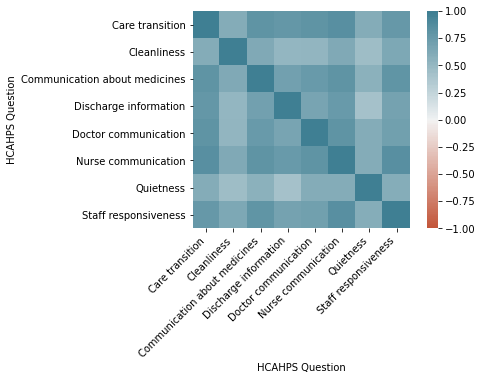

In [172]:
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## 3. Initial Modeling

In [28]:
# XGBoost Regressor
xgb = XGBRegressor(n_jobs=-1, tree_method='gpu_hist')

params = {
    'n_estimators': [300, 400],
    'max_depth': [2, 3],
    'learning_rate': [0.02, 0.08, 0.05],
    'subsample': [0.75, 0.8, 0.9],
    'colsample_bytree': [1]
}

xgb_gs = GridSearchCV(xgb, params, cv=5, verbose=1, n_jobs=-1, scoring='r2')
xgb_gs.fit(X, y)

xgb_best = xgb_gs.best_estimator_

print(f"Best params = {xgb_gs.best_params_}")
print(f"Best score = {xgb_gs.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[23:11:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1


C:\Users\baile\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  if y is not None:


XGBoostError: [23:11:43] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:588: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

### Non-gpu model with best parameters

In [173]:
parameters = {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.8}
xgb_best = XGBRegressor(**parameters)

[0.52755505 0.05235527 0.01428115 0.01862424 0.04813996 0.30138883
 0.0196848  0.01797071]


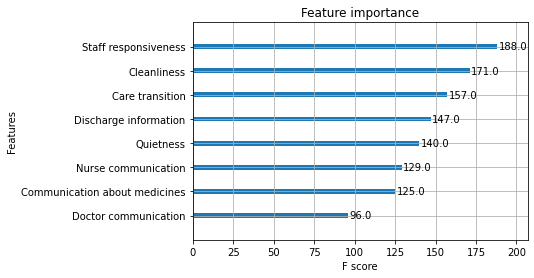

In [174]:
xgb_best.fit(X_train, y_train)
# feature importance
print(xgb_best.feature_importances_)
# plot
plot_importance(xgb_best)
plt.show()

In [35]:
visualizer = LearningCurve(xgb_best, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

NameError: name 'LearningCurve' is not defined

## 4. Introduce External Data Sources
1. Hospital Medicare Spending
    - Does a hospital spend more or less than the national average

In [7]:
medicare_data = pd.read_csv('HOSPITAL_QUARTERLY_MSPB_6_DECIMALS.csv', na_values=['Not Applicable', 'Not Available'],
                           usecols=[0, 2])

medicare_data.rename(columns={"Value": "Medicare_Spend"}, inplace=True)
medicare_data['Facility ID'] = medicare_data['Facility ID'].astype(str)
medicare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Facility ID     3046 non-null   object 
 1   Medicare_Spend  2511 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.7+ KB


___
2. Unplanned Hospital Visits
    - How does a hospital score for unplanned visits following procedures

In [48]:
unplanned_data = pd.read_csv('C:/Users/baile/Downloads/Unplanned_Hospital_Visits-Hospital.csv', na_values=['Not Applicable', 'Not Available'],
                            low_memory=False, usecols=[0, 8, 12])

unplanned_data = unplanned_data.pivot_table(index="Facility ID", columns="Measure ID", values="Score")
unplanned_data['Unplanned_Score'] = unplanned_data.mean(axis=1)
#unplanned_data.reset_index(inplace=True)
unplanned_data = unplanned_data[['Unplanned_Score']]

unplanned_data.head()

Measure ID,Unplanned_Score
Facility ID,
010001,10.664286
010005,9.730769
010006,12.450000
010007,14.262500
010008,13.880000


___
3. Income by Zip Code

In [38]:
income_data = pd.read_csv('2020-zipcode-income.csv')
income_data['Median income (dollars)'] = pd.to_numeric(income_data['Median income (dollars)'], errors='coerce')
income_data['Zip Code'] = income_data['Zip Code'].str[6:].astype('int64')
income_data = income_data.rename(columns={'Zip Code':'ZIP Code'})
#income_data = income_data.set_index('Zip Code')

income_data.head()

,ZIP Code,Median income (dollars)
0,601,14398.0
1,602,16771.0
2,603,15786.0
3,606,14980.0
4,610,20167.0


4. General Hospital Info
    - What type of hospital

In [20]:
# Read 'Hospital General Information' Data
hospital_data = pd.read_csv('Hospital_General_Information.csv', na_values=['Not Applicable', 'Not Available'],
                           low_memory=False, usecols=[0, 5, 8, 9, 10])
hospital_data.head()

,Facility ID,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services
0,010001,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes
1,010005,35957,Acute Care Hospitals,Government - Hospital District or Authority,Yes
2,010006,35630,Acute Care Hospitals,Proprietary,Yes
3,010007,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes
4,010008,36049,Acute Care Hospitals,Proprietary,Yes


## Merge External Data Sources

In [66]:
# Merge columns of interest from general hospital information with HCAHPS dataset
df2 = pd.merge(df, hospital_data, on = 'Facility ID')
df2.head()

,Facility ID,Care transition - linear mean score,Cleanliness - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Doctor communication - linear mean score,Nurse communication - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score,Staff responsiveness - linear mean score,hospital_score,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services
0,010001,81.0,87.0,77.0,89.0,92.0,90.0,88.0,84.0,90.0,81.0,89.0,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes
1,010005,81.0,83.0,73.0,85.0,93.0,89.0,86.0,85.0,84.0,74.0,85.0,35957,Acute Care Hospitals,Government - Hospital District or Authority,Yes
2,010006,77.0,77.0,72.0,84.0,90.0,86.0,82.0,84.0,82.0,72.0,82.0,35630,Acute Care Hospitals,Proprietary,Yes
3,010007,80.0,86.0,89.0,90.0,94.0,94.0,87.0,86.0,85.0,87.0,86.0,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes
4,010011,81.0,83.0,77.0,86.0,91.0,90.0,87.0,82.0,88.0,83.0,87.5,35235,Acute Care Hospitals,Voluntary non-profit - Private,Yes


In [67]:
df2 = df2.astype({'Hospital Type': 'category', 'Hospital Ownership': 'category', 'Emergency Services':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3024
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   Facility ID                                        3025 non-null   object  
 1   Care transition - linear mean score                3025 non-null   float64 
 2   Cleanliness - linear mean score                    3025 non-null   float64 
 3   Communication about medicines - linear mean score  3025 non-null   float64 
 4   Discharge information - linear mean score          3025 non-null   float64 
 5   Doctor communication - linear mean score           3025 non-null   float64 
 6   Nurse communication - linear mean score            3025 non-null   float64 
 7   Overall hospital rating - linear mean score        3025 non-null   float64 
 8   Quietness - linear mean score                      3025 non-null   float64 
 9

In [68]:
# Merge medicare data
df2 = df2.merge(medicare_data, on = 'Facility ID')
df2.head()

,Facility ID,Care transition - linear mean score,Cleanliness - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Doctor communication - linear mean score,Nurse communication - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score,Staff responsiveness - linear mean score,hospital_score,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Medicare_Spend
0,100001,80.0,83.0,76.0,86.0,89.0,89.0,86.0,82.0,86.0,82.0,86.0,32209,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.028082
1,100002,75.0,81.0,68.0,77.0,86.0,86.0,84.0,84.0,83.0,74.0,83.5,33435,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.098757
2,100006,82.0,87.0,73.0,85.0,91.0,91.0,89.0,85.0,90.0,83.0,89.5,32806,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.004443
3,100007,82.0,88.0,78.0,87.0,89.0,91.0,89.0,87.0,89.0,82.0,89.0,32803,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.003360
4,100008,81.0,83.0,74.0,82.0,92.0,89.0,87.0,84.0,89.0,78.0,88.0,33176,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.008853


In [69]:
# Merge median income
df2 = df2.merge(income_data, on = 'ZIP Code')
df2.head()

,Facility ID,Care transition - linear mean score,Cleanliness - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Doctor communication - linear mean score,Nurse communication - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score,Staff responsiveness - linear mean score,hospital_score,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Medicare_Spend,Median income (dollars)
0,100001,80.0,83.0,76.0,86.0,89.0,89.0,86.0,82.0,86.0,82.0,86.0,32209,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.028082,26568.0
1,100002,75.0,81.0,68.0,77.0,86.0,86.0,84.0,84.0,83.0,74.0,83.5,33435,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.098757,52785.0
2,100006,82.0,87.0,73.0,85.0,91.0,91.0,89.0,85.0,90.0,83.0,89.5,32806,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.004443,72533.0
3,100007,82.0,88.0,78.0,87.0,89.0,91.0,89.0,87.0,89.0,82.0,89.0,32803,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.003360,82111.0
4,100008,81.0,83.0,74.0,82.0,92.0,89.0,87.0,84.0,89.0,78.0,88.0,33176,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.008853,74246.0


In [70]:
# Merge survey response rate
surveyresponse = data[['Facility ID','Survey Response Rate Percent']].drop_duplicates()
df2 = df2.merge(surveyresponse, on = 'Facility ID')
df2.head()

,Facility ID,Care transition - linear mean score,Cleanliness - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Doctor communication - linear mean score,Nurse communication - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score,Staff responsiveness - linear mean score,hospital_score,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Medicare_Spend,Median income (dollars),Survey Response Rate Percent
0,100001,80.0,83.0,76.0,86.0,89.0,89.0,86.0,82.0,86.0,82.0,86.0,32209,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.028082,26568.0,28.0
1,100002,75.0,81.0,68.0,77.0,86.0,86.0,84.0,84.0,83.0,74.0,83.5,33435,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.098757,52785.0,21.0
2,100006,82.0,87.0,73.0,85.0,91.0,91.0,89.0,85.0,90.0,83.0,89.5,32806,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.004443,72533.0,16.0
3,100007,82.0,88.0,78.0,87.0,89.0,91.0,89.0,87.0,89.0,82.0,89.0,32803,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.003360,82111.0,17.0
4,100008,81.0,83.0,74.0,82.0,92.0,89.0,87.0,84.0,89.0,78.0,88.0,33176,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.008853,74246.0,15.0


In [165]:
df2 = df2.rename(columns={'Care transition - linear mean score':'Care transition','Cleanliness - linear mean score':'Cleanliness','Communication about medicines - linear mean score':'Communication about medicines','Discharge information - linear mean score':'Discharge information','Doctor communication - linear mean score':'Doctor communication','Nurse communication - linear mean score':'Nurse communication','Overall hospital rating - linear mean score':'Overall hospital rating','Quietness - linear mean score':'Quietness',})
df2.head()

,Facility ID,Care transition,Cleanliness,Communication about medicines,Discharge information,Doctor communication,Nurse communication,Overall hospital rating,Quietness,Recommend hospital - linear mean score,Staff responsiveness - linear mean score,hospital_score,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Medicare_Spend,Median income (dollars),Survey Response Rate Percent
0,100001,80.0,83.0,76.0,86.0,89.0,89.0,86.0,82.0,86.0,82.0,86.0,32209,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.028082,26568.0,28.0
1,100002,75.0,81.0,68.0,77.0,86.0,86.0,84.0,84.0,83.0,74.0,83.5,33435,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.098757,52785.0,21.0
2,100006,82.0,87.0,73.0,85.0,91.0,91.0,89.0,85.0,90.0,83.0,89.5,32806,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.004443,72533.0,16.0
3,100007,82.0,88.0,78.0,87.0,89.0,91.0,89.0,87.0,89.0,82.0,89.0,32803,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.003360,82111.0,17.0
4,100008,81.0,83.0,74.0,82.0,92.0,89.0,87.0,84.0,89.0,78.0,88.0,33176,Acute Care Hospitals,Voluntary non-profit - Private,Yes,1.008853,74246.0,15.0


## Hospital General Information EDA

In [77]:
# Aggregate hospital score by Hospital Type
aveincomebyresponse = df2.groupby('Survey Response Rate Percent').agg('mean')['Median income (dollars)'].reset_index()
aveincomebyresponse.head()

,Survey Response Rate Percent,Median income (dollars)
0,4.0,57183.000000
1,5.0,42583.000000
2,6.0,41869.000000
3,7.0,46841.416667
4,8.0,39432.812500


Text(0, 0.5, 'Median Income (dollars)')

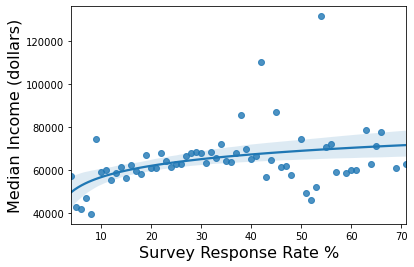

In [161]:
p1 = sns.regplot(x = aveincomebyresponse['Survey Response Rate Percent'],y = aveincomebyresponse['Median income (dollars)'], logx=True)
p1.set_xlabel('Survey Response Rate %', fontsize = 16)
p1.set_ylabel('Median Income (dollars)', fontsize = 16)

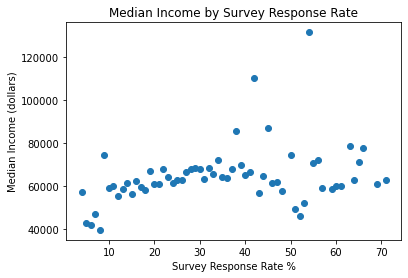

In [157]:
# Scatter plot of survey response rate vs. median income
plt.scatter(x = aveincomebyresponse['Survey Response Rate Percent'], y = aveincomebyresponse['Median income (dollars)'])
plt.title('Median Income by Survey Response Rate')
plt.xlabel('Survey Response Rate %')
plt.ylabel('Median Income (dollars)')
plt.show()

Text(0, 0.5, 'Hospital Rating')

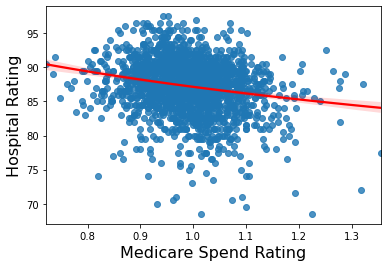

In [176]:
p1 = sns.regplot(x = df2['Medicare_Spend'], y = df2['hospital_score'], logx=True, line_kws={'color':'red'})
p1.set_xlabel('Medicare Spend Rating', fontsize = 16)
p1.set_ylabel('Hospital Rating', fontsize = 16)

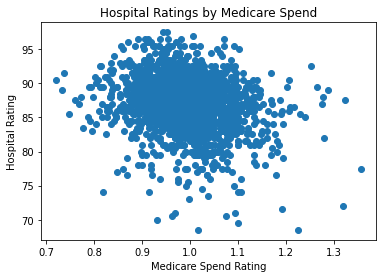

In [42]:
# Scatter plot of medicare spend vs. hospital rating
plt.scatter(x = df2['Medicare_Spend'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Medicare Spend')
plt.xlabel('Medicare Spend Rating')
plt.ylabel('Hospital Rating')
plt.show()

Text(0, 0.5, 'Hospital Score')

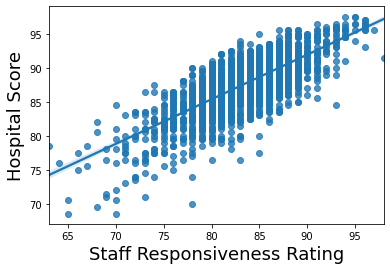

In [84]:
p1 = sns.regplot(x = df2['Staff responsiveness - linear mean score'],y = df2['hospital_score'])
p1.set_xlabel('Staff Responsiveness Rating', fontsize = 18)
p1.set_ylabel('Hospital Score', fontsize = 18)

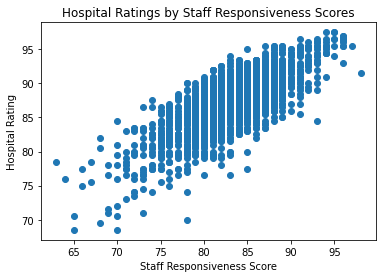

In [16]:
# Scatter plot of staff responsiveness vs. hospital rating
plt.scatter(x = df2['Staff responsiveness - linear mean score'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Staff Responsiveness Scores')
plt.xlabel('Staff Responsiveness Score')
plt.ylabel('Hospital Score')
plt.show()

Text(0, 0.5, 'Hospital Score')

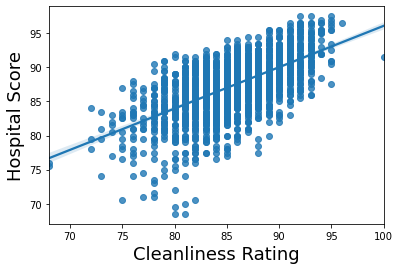

In [85]:
p1 = sns.regplot(x = df2['Cleanliness - linear mean score'],y = df2['hospital_score'])
p1.set_xlabel('Cleanliness Rating', fontsize = 18)
p1.set_ylabel('Hospital Score', fontsize = 18)

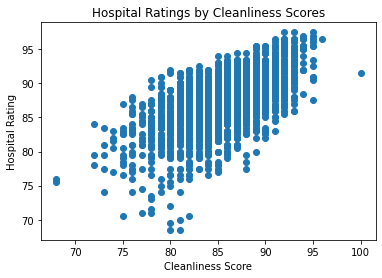

In [17]:
# Scatter plot of cleanliness vs. hospital rating
plt.scatter(x = df2['Cleanliness - linear mean score'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Cleanliness Scores')
plt.xlabel('Cleanliness Score')
plt.ylabel('Hospital Rating')
plt.show()

Text(0, 0.5, 'Hospital Score')

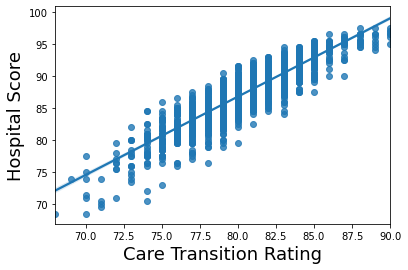

In [86]:
p1 = sns.regplot(x = df2['Care transition - linear mean score'],y = df2['hospital_score'])
p1.set_xlabel('Care Transition Rating', fontsize = 18)
p1.set_ylabel('Hospital Score', fontsize = 18)

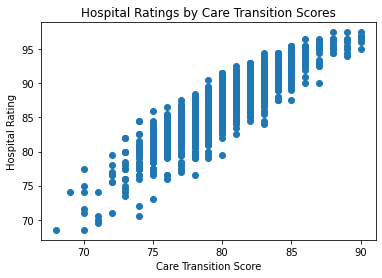

In [18]:
plt.scatter(x = df2['Care transition - linear mean score'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Care Transition Scores')
plt.xlabel('Care Transition Score')
plt.ylabel('Hospital Rating')
plt.show()

Text(0, 0.5, 'Hospital Score')

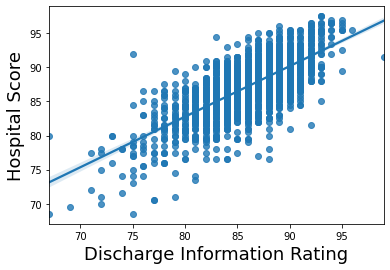

In [87]:
p1 = sns.regplot(x = df2['Discharge information - linear mean score'],y = df2['hospital_score'])
p1.set_xlabel('Discharge Information Rating', fontsize = 18)
p1.set_ylabel('Hospital Score', fontsize = 18)

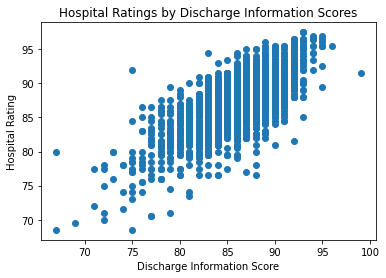

In [19]:
plt.scatter(x = df2['Discharge information - linear mean score'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Discharge Information Scores')
plt.xlabel('Discharge Information Score')
plt.ylabel('Hospital Rating')
plt.show()

Text(0, 0.5, 'Hospital Score')

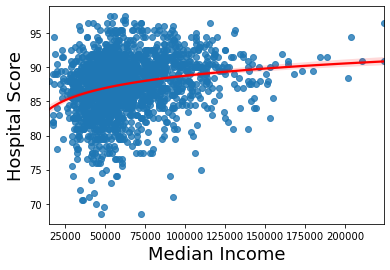

In [153]:
p1 = sns.regplot(x = df2['Median income (dollars)'],y = df2['hospital_score'], logx = True, line_kws={'color':'red'})
p1.set_xlabel('Median Income', fontsize = 18)
p1.set_ylabel('Hospital Score', fontsize = 18)

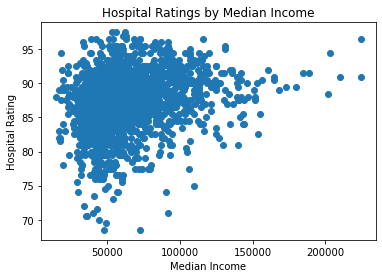

In [41]:
# Scatter plot of staff responsiveness vs. hospital rating
plt.scatter(x = df2['Median income (dollars)'], y = df2['hospital_score'])
plt.title('Hospital Ratings by Median Income')
plt.xlabel('Median Income')
plt.ylabel('Hospital Rating')
plt.show()

In [54]:
# Aggregate hospital score by Hospital Type
df2.groupby('Hospital Type').agg('mean')['hospital_score']

Hospital Type
Acute Care - Department of Defense          NaN
Acute Care Hospitals                  87.393443
Critical Access Hospitals                   NaN
Name: hospital_score, dtype: float64

In [90]:
# Aggregate hospital score by Hospital Ownership
ownerscores = df2.groupby('Hospital Ownership').agg('mean')['hospital_score'].reset_index()
ownerscores

,Hospital Ownership,hospital_score
0,Department of Defense,NaN
1,Government - Federal,88.000000
2,Government - Hospital District or Authority,86.903101
3,Government - Local,87.207921
4,Government - State,86.968750
5,Physician,92.478261
6,Proprietary,86.039340
7,Tribal,89.750000
8,Voluntary non-profit - Church,87.628743
9,Voluntary non-profit - Other,87.638122


In [93]:
avescore = df2['hospital_score'].mean()
avescore

87.37421837421837

Text(0.55, 88, 'Average Score: 87.4')

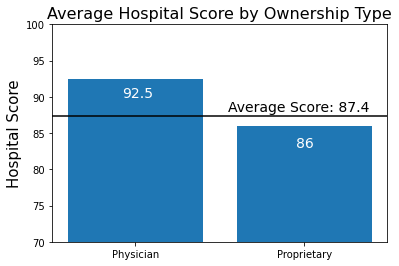

In [145]:
plotowners = ownerscores[ownerscores['Hospital Ownership'].isin(['Physician','Proprietary'])]
plotowners
plt.bar(plotowners['Hospital Ownership'], plotowners['hospital_score'])
plt.ylim(70,100)
plt.title('Average Hospital Score by Ownership Type', fontsize=16)
plt.ylabel('Hospital Score', fontsize=15)
plt.axhline(y=87.37421837421837, color='black', linestyle='-')
plt.text(x = -0.08, y =90, s = '92.5', color = 'white', fontsize = 14)
plt.text(x = .95, y = 83, s = '86', color = 'white', fontsize = 14)
plt.text(x = .55, y = 88, s = 'Average Score: 87.4', fontsize = 14)

In [56]:
# Aggregate hospital score by Emergency Services
df2.groupby('Emergency Services').agg('mean')['hospital_score']

Emergency Services
No     90.933628
Yes    87.201392
Name: hospital_score, dtype: float64

## Create Dummy Variables

In [57]:
df2 = pd.get_dummies(data = df2, columns = ['Hospital Type','Hospital Ownership','Emergency Services'])
df2.head()

,Facility ID,Care transition - linear mean score,Cleanliness - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Doctor communication - linear mean score,Nurse communication - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score,...,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_No,Emergency Services_Yes
0,100001,80.0,83.0,76.0,86.0,89.0,89.0,86.0,82.0,86.0,...,0,0,0,0,0,0,0,1,0,1
1,100002,75.0,81.0,68.0,77.0,86.0,86.0,84.0,84.0,83.0,...,0,0,0,0,0,0,0,1,0,1
2,100006,82.0,87.0,73.0,85.0,91.0,91.0,89.0,85.0,90.0,...,0,0,0,0,0,0,0,1,0,1
3,100007,82.0,88.0,78.0,87.0,89.0,91.0,89.0,87.0,89.0,...,0,0,0,0,0,0,0,1,0,1
4,100008,81.0,83.0,74.0,82.0,92.0,89.0,87.0,84.0,89.0,...,0,0,0,0,0,0,0,1,0,1


In [62]:
# Set predictor and target features
X = df2.drop(columns=['Facility ID',
                     'Overall hospital rating - linear mean score',
                     'Recommend hospital - linear mean score',
                     'hospital_score'])

y = df2.hospital_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Rerun Model with New Data

In [63]:
# Standardize Data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

In [153]:
# XGBoost Regressor
xgb = XGBRegressor(n_jobs=-1, tree_method='gpu_hist')

params = {
    'n_estimators': [300, 400],
    'max_depth': [2, 3],
    'learning_rate': [0.02, 0.08, 0.05],
    'subsample': [0.75, 0.8, 0.9],
    'colsample_bytree': [1]
}

xgb_gs = GridSearchCV(xgb, params, cv=5, verbose=1, n_jobs=-1, scoring='r2')
xgb_gs.fit(X_scaled, y)

xgb_best = xgb_gs.best_estimator_

print(f"Best params = {xgb_gs.best_params_}")
print(f"Best score = {xgb_gs.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params = {'colsample_bytree': 1, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.75}
Best score = 0.8214601199141832


### This chunk is for my non-gpu machine

In [64]:
para = {'colsample_bytree': 1, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.75}
xgb_best = XGBRegressor(**para)

[0.4415938  0.03526787 0.02067428 0.01579801 0.0667723  0.23563348
 0.0372417  0.02216958 0.01586113 0.         0.         0.
 0.         0.         0.01172905 0.01220662 0.00893654 0.
 0.01821177 0.         0.01125144 0.01442409 0.01585532 0.01637305
 0.        ]


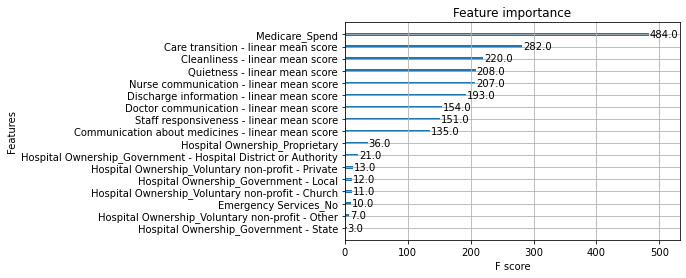

In [65]:
xgb_best.fit(X_train, y_train)
# feature importance
print(xgb_best.feature_importances_)
# plot
plot_importance(xgb_best)
plt.show()

### Feature selection to look at number of variables and associated R2
#### based off this link https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [71]:
thresholds = sort(xgb_best.feature_importances_)
for thresh in thresholds:
    para = {'colsample_bytree': 1, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.75}
    # select features using threshold
    selection = SelectFromModel(xgb_best, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor(**para)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = r2_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.000, n=25, Accuracy: 81.55%
Thresh=0.009, n=17, Accuracy: 81.55%
Thresh=0.011, n=16, Accuracy: 81.58%
Thresh=0.012, n=15, Accuracy: 81.56%
Thresh=0.012, n=14, Accuracy: 81.48%
Thresh=0.014, n=13, Accuracy: 81.54%
Thresh=0.016, n=12, Accuracy: 81.68%
Thresh=0.016, n=11, Accuracy: 81.38%
Thresh=0.016, n=10, Accuracy: 81.41%
Thresh=0.016, n=9, Accuracy: 81.08%
Thresh=0.018, n=8, Accuracy: 81.20%
Thresh=0.021, n=7, Accuracy: 81.53%
Thresh=0.022, n=6, Accuracy: 81.12%
Thresh=0.035, n=5, Accuracy: 81.63%
Thresh=0.037, n=4, Accuracy: 80.49%
Thresh=0.067, n=3, Accuracy: 80.14%
Thresh=0.236, n=2, Accuracy: 79.84%
Thresh=0.442, n=1, Accuracy: 76.36%
